In [ ]:
!pip install torch torchvision pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 9.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

The `AffineCouplingLayer` performs an affine transformation on one half of the input while the other half remains unchanged.

*The transformation parameters s and t are obtained from a neural network.*


The **scale parameter** s determines *how much to scale or stretch the input data along a certain dimension*. It is applied multiplicatively.

Formula: In the forward transformation, the scaling is applied as:

y2 = x2 * exp(s)

In the inverse transformation, the scaling is reversed as:

x2=y2×exp(−s)

Interpretation: The exp(s) function ensures that the scaling factor is always positive, which maintains the invertibility of the transformation

-------------------

The **translation parameter** t determines *how much to shift the input data along a certain dimension*. It is applied additively.

Formula: In the forward transformation, the translation is applied as:

y2=x2+t

In the inverse transformation, the translation is reversed as:

x2=y2−t

Interpretation: The translation parameter t allows the model to shift the input data to adjust its position, enhancing the flexibility of the transformation.

In [ ]:
# Define Affine Coupling Layer
class AffineCouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_dim):
        super(AffineCouplingLayer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_channels)
        )

    def forward(self, x, log_det_jacobian, reverse=False):
        #The input tensor x is split into two halves, x1 and x2, along the channel dimension.
        #This is the key idea of coupling layers, where one half of the data is transformed conditioned on the other half.
        x1, x2 = x.chunk(2, dim=1)
        if not reverse:
            #The neural network self.net processes x1 to produce s (scale) and t (translation) parameters.
            s, t = self.net(x1).chunk(2, dim=1)
            s = torch.tanh(s)
            y1 = x1
            y2 = x2 * torch.exp(s) + t
            #The log-determinant of the Jacobian (log_det_jacobian) is updated by adding the sum of s.
            #This log-determinant term is essential for maintaining the correct probability density transformation.
            log_det_jacobian += s.sum(dim=1)
        else:
            s, t = self.net(x1).chunk(2, dim=1)
            s = torch.tanh(s)
            y1 = x1
            y2 = (x2 - t) * torch.exp(-s)
            log_det_jacobian -= s.sum(dim=1)
        return torch.cat([y1, y2], dim=1), log_det_jacobian

The **NormalizingFlowModel** consists of a series of AffineCouplingLayer layers.

The **forward** method applies the normalizing flow transformations and computes the log determinant of the Jacobian.

The **inverse** method reverses the transformations to sample from the model.

The **training_step** method computes the loss based on the negative log-likelihood of the transformed data.

In [ ]:
class NormalizingFlowModel(pl.LightningModule):
    def __init__(self, num_flows=4, hidden_dim=128):
        super(NormalizingFlowModel, self).__init__()
        self.flows = nn.ModuleList([AffineCouplingLayer(784, hidden_dim) for _ in range(num_flows)])
        self.base_dist = torch.distributions.Normal(0, 1)

    def forward(self, x):
        log_det_jacobian = torch.zeros(x.size(0), device=x.device)
        for flow in self.flows:
            x, log_det_jacobian = flow(x, log_det_jacobian)
        return x, log_det_jacobian

    def inverse(self, z):
        log_det_jacobian = torch.zeros(z.size(0), device=z.device)
        for flow in reversed(self.flows):
            z, log_det_jacobian = flow(z, log_det_jacobian, reverse=True)
        return z, log_det_jacobian

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        z, log_det_jacobian = self(x)
        log_prob = self.base_dist.log_prob(z).sum(dim=1)
        loss = -(log_prob + log_det_jacobian).mean()
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    def sample(self, num_samples):
        z = self.base_dist.sample((num_samples, 784)).to(self.device)
        x, _ = self.inverse(z)
        return x

    def reconstruct(self, x):
        z, _ = self(x)
        x_reconstructed, _ = self.inverse(z)
        return x_reconstructed


In [ ]:
# Prepare the MNIST dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_train = MNIST(root='.', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

# Train the model using PyTorch Lightning
model = NormalizingFlowModel(num_flows=4, hidden_dim=128)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, train_loader)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16354180.15it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479724.42it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4505857.12it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5390641.98it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | flows | ModuleList | 671 K 
-------------------------------------
671 K     Trainable params
0         Non-trainable params
671 K     Total params
2.687     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


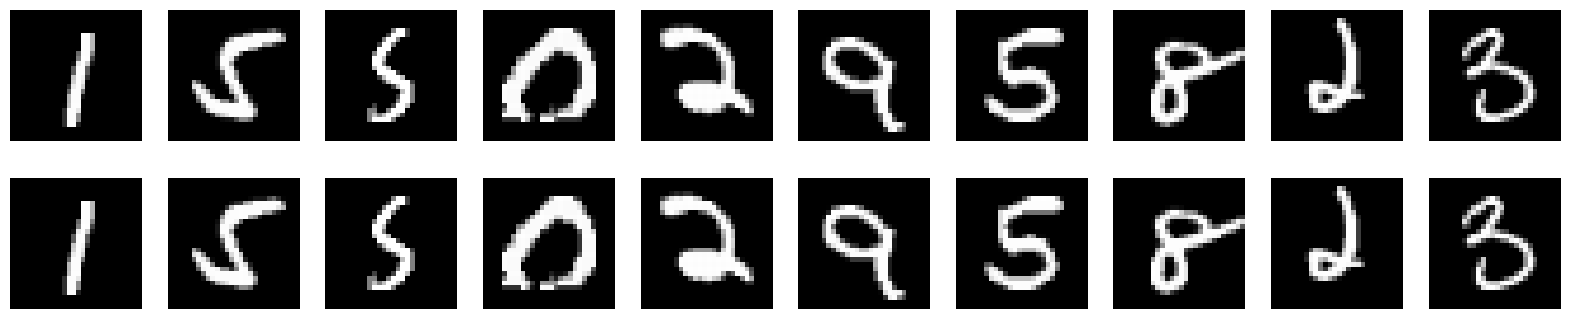

In [ ]:
# Function to visualize original and reconstructed images
def visualize_reconstruction(model, data_loader, num_images=10):
    model.eval()
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images.view(images.size(0), -1).to(model.device)

    with torch.no_grad():
        reconstructed_images = model.reconstruct(images)

    images = images.view(-1, 28, 28).cpu().numpy()
    reconstructed_images = reconstructed_images.view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i], cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize the results
visualize_reconstruction(model, train_loader)

In [ ]:
# Function to visualize generated images
def visualize_generated(model, num_images=10):
    model.eval()
    with torch.no_grad():
        generated_images = model.sample(num_images)

    generated_images = generated_images.view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

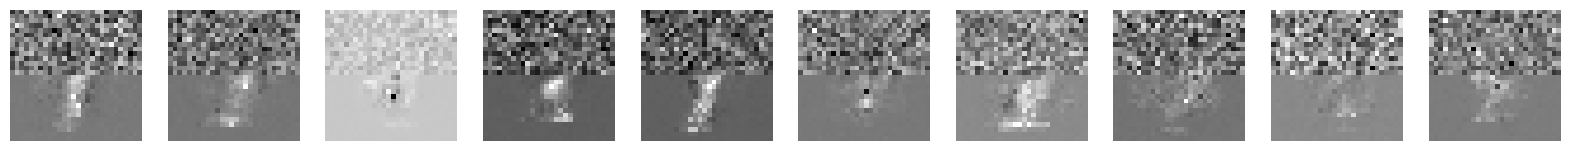

In [ ]:
visualize_generated(model, num_images=10)

The generated images are sampled from the base distribution (usually a standard normal distribution) and then transformed through the normalizing flow model.

The reconstructed images are obtained by encoding the original images into the latent space using the normalizing flow model and then decoding them back to the image space.

The goal of reconstruction is to faithfully represent the original input. Therefore, the reconstructed images should closely resemble the original images in the training set.